In [1]:
%matplotlib inline

import numpy as np # NUMPY
import pandas as pd # PANDAS
import matplotlib.pyplot as plt # MATPLOTLIB
import seaborn as sns # SEABORN
import scipy
import sklearn
from sklearn.decomposition import PCA
import cv2
import os 
from skimage import filters
from scipy import ndimage

In [2]:
cant_frames_per_seq = pd.read_csv('ckmock_landmark_FramePerSeq.csv',header = None)
cant_frames_per_seq = np.asarray(cant_frames_per_seq).flatten()

subject_images = []
warpimgpath = '../ck+warped'
for i in range(0, len(os.listdir(warpimgpath))):
    subject_images.append('../ck+warped/' + 'warped_image_procustres_' + str(i)+'.png')
subject_images = np.asarray(subject_images)

img = cv2.imread(subject_images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
width, height = img.shape
width, height

(490, 640)

In [3]:
img = cv2.imread(subject_images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imshow("Texture start", img)
# Pause screen to wait key from user to see result
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite("ejemplotex.png", img)

True

In [4]:
from skimage import filters

def ComputeImageGradient(image, way):
    if way == 0:
        GradX = cv2.Sobel(image, ddepth=-1, dx=1, dy=0, borderType=cv2.BORDER_REFLECT)
        GradY = cv2.Sobel(image, ddepth=-1, dx=0, dy=1, borderType=cv2.BORDER_REFLECT)
        GradX[-1,:] = 0
        GradY[:, -1] = 0 # Neumann boundary Condition
    elif way == 1:
        GradX, GradY = np.gradient(image)      
        GradX[-1,:] = 0
        GradY[:, -1] = 0 # Neumann boundary Condition     
    elif way == 2: 
        Kx = -1*np.array([[-1,0,1]])
        GradX = ndimage.convolve(img, Kx)
        Ky = -1*np.array([[-1],[0],[1]])
        GradY = ndimage.convolve(img, Ky)
        GradX[-1,:] = 0
        GradY[:, -1] = 0 # Neumann boundary Condition  
    else:
        print('not legal way')
        GradY = np.zeros(image.shape)
        GradX = np.zeros(image.shape)
    return GradX, GradY


ComputeImageGradient(img,  0)
#gradx



(array([[109, 255, 255, ...,   0,   0,   0],
        [ 83, 255, 255, ...,   0,   0,   0],
        [ 32,  92, 110, ...,   0,   0,   0],
        ...,
        [  4,   9,  10, ...,   0,   0,   0],
        [  3,   6,   8, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8),
 array([[ 1,  9, 17, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  1,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8))

In [5]:
from numpy import linalg as LA
def ProximalF_Star(img_p1,img_p2):
    inp1 = img_p1.flatten()    
    inp2 = img_p2.flatten()# (313600,1)
    p_total =  np.dstack((inp1, inp2)) # queda (1,313600,2)
    p_total = p_total[0]

    partial = np.zeros(len(p_total))
    
    partial = np.asarray(list(map(LA.norm, p_total))) # cada el de p_total la norma 2
    partial = np.asarray(list(map(lambda e: max(1.0,e), partial)))
    
    partial = partial.reshape(img_p1.shape)
    
    output_img_p1 = img_p1 / partial
    output_img_p2 = img_p1 / partial 


    return output_img_p1, output_img_p2


In [37]:
LA.norm([1,3], ord = 2)

3.1622776601683795

In [38]:
(1**2+3**2)**(1/2)

3.1622776601683795

In [6]:
def ComputeDivergenceL(img_p1, img_p2, way=1, sp=[1,1]):
    if way == 0 :
        p1_dx =  cv2.Sobel(img_p1, ddepth=-1, dx=1, dy=0, borderType=cv2.BORDER_REFLECT)
        p2_dy =  cv2.Sobel(img_p2, ddepth=-1, dx=0, dy=1, borderType=cv2.BORDER_REFLECT)
        output_image = p1_dx + p2_dy
    elif way == 1 :
        width, height =img_p1.shape
        inp1 = img_p1.flatten()
        inp2 = img_p2.flatten()#no se si f o c
        vector_field = np.array([inp1, inp2])
        num_dims = 2        
        output_image = np.ufunc.reduce(np.add, [np.gradient(vector_field[i], sp[i], axis =0) for i in range(num_dims)]) 
        output_image = output_image.reshape(width,height)        
    return output_image

In [7]:
def ProximalG(img_u, img_g, landa, tau):
    resta = img_u - img_g    
    output_image = np.zeros(img_u.shape)
    for i in range(0, len(img_u)):
        for j in range(0, len(img_u[i])):            
            if resta[i][j] > landa*tau :
                output_image[i][j] = img_u[i][j] - (landa*tau)
            elif resta[i][j] < -1*(landa*tau):
                output_image[i][j] = img_u[i][j] + (landa*tau)
            else: # si el modulo de la resta es menor a landa*tau
                output_image[i][j] = img_g[i][j]
    return output_image

Vamos ahora si a tratar de hacer la decomposition con el paper

In [8]:
def Chambolle_TV_L1(input_image, nb_iter, tau, sigma, landa, tetha, way):
    # inicializacion
    width, height  = input_image.shape
    size_image = width * height
    
    u = input_image    
    u_old = np.zeros(input_image.shape)    
    p1 =  np.zeros(input_image.shape)# p = (p1, p2) o (px, py)
    p2= np.zeros(input_image.shape)
    img1 = np.zeros(input_image.shape)
    img2 = np.zeros(input_image.shape)
    GradX = np.zeros(input_image.shape)
    GradY = np.zeros(input_image.shape)
    
    E = float('inf')
    
        
    for it in range (1, nb_iter):
        u_old = u
        GradX, GradY = ComputeImageGradient(u, way) 
        im1 = p1+ sigma*GradX
        im2 = p2 + sigma*GradY
        p1, p2 = ProximalF_Star(im1,im2)        
        div = ComputeDivergenceL(p1, p2)        
        image1 = u + tau*div
        u = ProximalG(image1, input_image, landa, tau)
        u = u + tetha* (u - u_old)
        
        if( it % 10 == 0):
            E_old = E
            E = 0
            GradX, GradY = ComputeImageGradient(u, way)
            E += np.sum(landa * abs(u-input_image) + np.sqrt(GradX**2 + GradY**2))
            E = E/size_image
            if(abs(E-E_old) < 0.001): break
    
    return u


In [42]:
def cartoonTexture_grey(input_image, landa, nb_iter_max=1000, tau=0.35, sigma=0.35, tetha =1.0, way =3):
    
    
    cartoon = np.zeros(input_image.shape)    
    cartoon = Chambolle_TV_L1(input_image, nb_iter_max, tau, sigma, landa, tetha, way)
    
    GradX = np.zeros(input_image.shape) 
    GradY = np.zeros(input_image.shape) 
    
    BV_norm = 0.0
    
    GradX, GradY = ComputeImageGradient(cartoon, way)
    
    BV_norm += np.sum((GradX **2 + GradY **2)**(1/2))     
    
    
    vLim = 20.0
    
    texture = np.zeros(input_image.shape)
    
    #texture = input_image - cartoon
    
    for i in range(0, len(texture)):
        for j in range(0, len(texture[i])):
            fValue = float(float(input_image[i][j]) - float(cartoon[i][j]))
            fValue =  (fValue + vLim) * 255.0 / (2.0 * vLim)
            if (fValue < 0.0): fValue = 0.0
            if (fValue > 255.0): fValue = 255.0
            texture[i][j] = fValue        
    return cartoon, texture
    


In [ ]:
Ahora tenemos los algoritmos vamos a

1) conseguir los cartoon textura para todas las imagenes
2) guardarlas en una database

 

In [11]:
cant_frames_per_seq = pd.read_csv('ckmock_landmark_FramePerSeq.csv',header = None)
cant_frames_per_seq = np.asarray(cant_frames_per_seq).flatten()

subject_images = []
warpimgpath = '../ck+warped'
for i in range(0, len(os.listdir(warpimgpath))):
    subject_images.append('../ck+warped/' + 'warped_image_procustres_' + str(i)+'.png')
subject_images = np.asarray(subject_images)

img = cv2.imread(subject_images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
width, height = img.shape
width, height

(490, 640)

In [31]:
subject_images = []
warpimgpath = '../ck+warped'
for i in range(0, len(os.listdir(warpimgpath))):
    subject_images.append('../ck+warped/' + 'warped_image_procustres_' + str(i)+'.png')
subject_images = np.asarray(subject_images)

img = cv2.imread(subject_images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img[40:450, 170:580]
cv2.imshow("Texture start", img)
# Pause screen to wait key from user to see result
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
for i in range (0, len(subject_images)):
    img = cv2.imread(subject_images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img2 = img[40:450, 170:580]
    print(img2.shape)
    cartoon, texture = cartoonTexture_grey(img2, 0.2, 50, 0.35, 0.35, 1.0, 0)
    cv2.imwrite("cartoon/cartoonimg" + str(i) +".png", cartoon)
    cv2.imwrite("texture/textureimg" + str(i)+".png", texture)

(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)
(410, 410)

In [3]:

cartoon_images = []
warpimgpath = 'cartoon/'
for i in range(0, len(os.listdir(warpimgpath))):
    cartoon_images.append('cartoon/' + 'cartoonimg' + str(i)+'.png')
cartoon_images = np.asarray(cartoon_images)

'cartoon/cartoonimg0.png'

In [6]:
counter = 0
state = 0
frame_counter = 0
subject_first = np.zeros(len(subject_images))
for i in range(0, len(subject_images)):
    subject_first[i] = state 
    counter = counter + 1
    if counter == cant_frames_per_seq[frame_counter]: 
        counter = 0
        state +=  cant_frames_per_seq[frame_counter]
        frame_counter += 1
        


In [8]:
subject_first.shape

(583,)

In [10]:
imcart = []
for i in cartoon_images:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    img_mean = img/np.mean(img)
    imcart.append(img_mean.flatten())
    
imcartoon = np.asarray(imcart)
imcartooncopy = []
for i in range(0, len(imcartoon) ):
    first_frame = int(subject_first[i])
    imca = imcartoon[i] - imcartoon[first_frame]
    imcartooncopy.append(np.asarray(imca))

imcartoonarray = np.asarray(imcartooncopy)
imcartoonarray.shape

my_df = pd.DataFrame(imcartoonarray)
my_df.to_csv('imcartoonarray.csv',header = False, index= False)


In [12]:
texture_images = []
warpimgpath = 'texture/'
for i in range(0, len(os.listdir(warpimgpath))):
    texture_images.append('texture/' + 'textureimg' + str(i)+'.png')
texture_images = np.asarray(texture_images)

In [14]:
imtext = []
for i in texture_images:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)    
    imtext.append(img.flatten())
    
imtextarray = np.asarray(imtext)
imtextarray.shape

my_df = pd.DataFrame(imtextarray)
my_df.to_csv('imtexturearray.csv',header = False, index= False)

In [11]:
my_data_forPCA = pd.read_csv('imcartoonarray.csv',header = None)
my_data_forPCA

,0,1,2,3,4,5,6,7,8,9,...,168090,168091,168092,168093,168094,168095,168096,168097,168098,168099
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.000106,-0.000106,-0.000106,-0.000106,-0.000106,-0.000106,-0.000106,-0.000106,-0.000106,-0.000106,...,-0.016197,-0.016198,-0.016199,-0.008105,-0.000012,0.008081,0.024269,0.016174,-0.008109,-0.024298
2,-0.008392,-0.008392,-0.008392,-0.008392,-0.008392,-0.008392,-0.008392,-0.008392,-0.008392,-0.008392,...,0.015399,0.007272,0.007206,0.007173,0.023230,0.023164,0.047381,0.039221,0.014905,0.014839
3,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,...,0.016214,0.008121,0.000028,0.016220,0.016222,0.000033,0.016223,0.000035,-0.024247,-0.032340
4,-0.004758,-0.004758,-0.004758,-0.004758,-0.004758,-0.004758,-0.004758,-0.004758,-0.004758,-0.004758,...,-0.016562,-0.024675,-0.016637,-0.000504,0.007535,0.023649,0.055970,0.039763,-0.000690,-0.000728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,-0.011520,0.006588,-0.005483,0.000554,-0.005483,0.006588,-0.005483,0.006588,-0.005483,0.006588,...,0.000603,0.000603,0.000603,0.000603,0.000603,0.000603,0.000603,0.000603,0.000603,0.000603
150,-0.006469,-0.000434,-0.006469,-0.000410,-0.000410,0.005625,-0.000410,0.005625,-0.000410,0.005625,...,0.006156,0.006156,0.006156,0.006156,0.006156,0.006156,0.006156,0.006156,0.006156,0.006156
151,0.019220,0.019190,0.019220,0.019220,0.019220,0.025255,0.019220,0.025255,0.019220,0.019190,...,0.007727,0.007727,0.007727,0.007727,0.007727,0.007727,0.007727,0.007727,0.007727,0.007727
152,-0.017239,-0.005113,-0.017239,-0.011147,-0.011147,-0.005113,-0.011147,-0.005113,-0.011147,-0.005113,...,0.014403,0.014403,0.014403,0.014403,0.014403,0.014403,0.014403,0.014403,0.014403,0.014403


In [12]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_landDiff = std_scaler.fit_transform(my_data_forPCA)
scaled_landDiff.shape

(154, 168100)

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=14)
pca.fit_transform(scaled_landDiff)
b_cartoon = pca.fit_transform(scaled_landDiff)
b_cartoon.shape # 

(154, 14)

In [14]:
print(sum(pca.explained_variance_ratio_))

0.8383171422653423


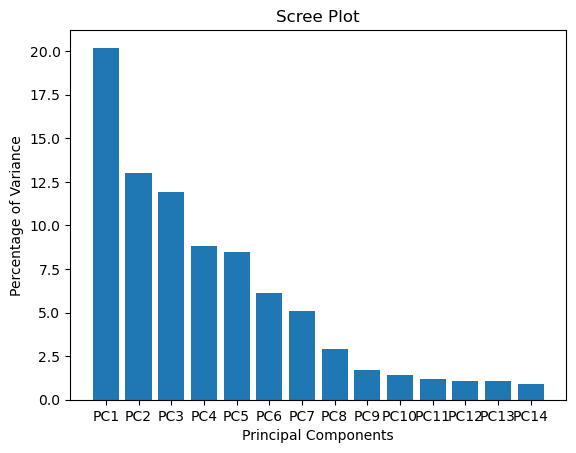

In [15]:
b_cartoon
pca_var=np.round(pca.explained_variance_ratio_* 100, decimals=1 )
labels = ['PC'+ str(s) for s in range(1, len(pca_var)+1)]

plt.bar(x= range(1, len(pca_var)+1), height = pca_var, tick_label= labels)
plt.ylabel("Percentage of Variance")
plt.xlabel("Principal Components")
plt.title("Scree Plot")
plt.show()

In [16]:
my_df = pd.DataFrame(b_cartoon)
my_df.to_csv('pca_cartoonpoints.csv',header = False, index= False)

In [10]:
my_data_forPCA2 = pd.read_csv('imtexturearray.csv',header = None)
my_data_forPCA2

,0,1,2,3,4,5,6,7,8,9,...,168090,168091,168092,168093,168094,168095,168096,168097,168098,168099
0,128,128,128,128,128,128,128,128,128,128,...,128,128,128,128,128,128,128,128,128,128
1,128,128,128,128,128,128,128,128,128,128,...,128,128,128,128,128,128,128,128,128,128
2,128,128,128,128,128,128,128,128,128,128,...,128,128,128,128,128,128,128,128,128,128
3,128,128,128,128,128,128,128,128,128,128,...,128,128,128,128,128,128,128,128,128,128
4,128,128,128,128,128,128,128,128,128,128,...,128,128,128,128,128,128,128,128,128,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,128,122,128,121,126,127,132,128,125,115,...,128,128,128,128,128,128,128,128,128,128
150,128,126,125,128,128,133,127,127,128,126,...,128,128,128,128,128,128,128,128,128,128
151,104,114,117,118,121,130,128,136,127,127,...,128,128,128,128,128,128,128,128,128,128
152,127,130,131,135,142,136,127,124,115,124,...,128,128,128,128,128,128,128,128,128,128


In [11]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_landDiff = std_scaler.fit_transform(my_data_forPCA2)
scaled_landDiff.shape

(154, 168100)

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit_transform(scaled_landDiff)
b_texture = pca.fit_transform(scaled_landDiff)
b_texture.shape # 

(154, 30)

In [13]:
print(sum(pca.explained_variance_ratio_))

0.5457880381820189


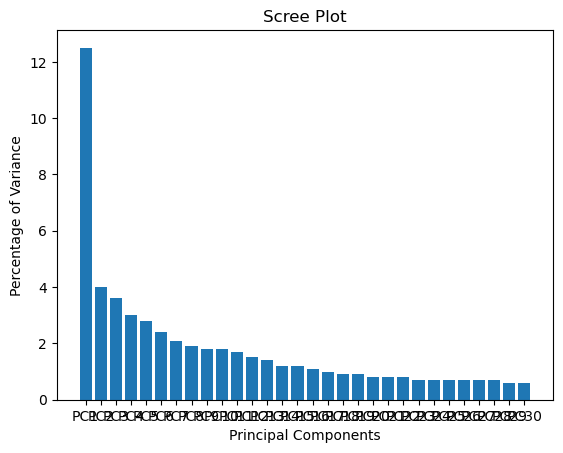

In [14]:
b_texture
pca_var=np.round(pca.explained_variance_ratio_* 100, decimals=1 )
labels = ['PC'+ str(s) for s in range(1, len(pca_var)+1)]

plt.bar(x= range(1, len(pca_var)+1), height = pca_var, tick_label= labels)
plt.ylabel("Percentage of Variance")
plt.xlabel("Principal Components")
plt.title("Scree Plot")
plt.show()

In [15]:
my_df = pd.DataFrame(b_texture)
my_df.to_csv('pca_texturepoints.csv',header = False, index= False)

In [22]:
cartoon, texture = cartoonTexture_grey(img, 0.7, 50, 0.35, 0.35, 1.0, 0)

cartoon, img, texture

NameError: name 'ProximalG' is not defined

In [23]:
Hori = np.concatenate((cartoon, texture), axis=1) 
cv2.imshow('Cartoon Texture', Hori) 
cv2.waitKey(0) 
cv2.destroyAllWindows()  

cv2.imwrite("ejemplotexcartoondescom07w0.png", Hori)

True

In [ ]:
To counter this dependence, for each face image we di-
vide each element of the u component by the mean value of
u of that ima

In [45]:
result = (cartoon_vector == a).all()
result

True